In [86]:
#libraries
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [260]:
#data

def get_historical_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False,interval="1wk")
    return data['Close']

# Define the tickers for the S&P 500 index and the 20 stocks
tickers = ['^DJI', 'UNH', 'MSFT', 'GS', 'HD', 'MCD', 'AMGN', 'CAT', 'V', 'CRM', 'BA', 'HON', 'AAPL', 'TRV', 'AXP', 'IBM', 'JPM', 'JNJ', 'WMT', 'PG', 'CVX', 'NKE', 'MRK', 'MMM', 'DIS', 'KO', 'DOW', 'CSCO', 'INTC', 'VZ', 'WBA']
# tickers = ['^GSPC', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'V', 'JNJ', 'UNH', 'BAC', 'TSLA', 'NVDA', 'WMT', 'PG', 'VZ', 'MA', 'HD', 'DIS', 'CMCSA']
# Calculate the start and end dates for the last six months
end = datetime.date.today() #out-of-sample
start = end  - datetime.timedelta(days=200) #out-of-sample

#out-of-sample prices
out_prices = get_historical_prices(tickers, start, end)

end_date = end  - datetime.timedelta(days=200) #in-sample
start_date = end_date - datetime.timedelta(days=500) #in-sample

# Retrieve the historical prices for the tickers
prices = get_historical_prices(tickers, start_date, end_date)

prices.shape,prices

((72, 31),
                   AAPL        AMGN         AXP          BA         CAT   
 Date                                                                     
 2022-01-10  173.070007  235.360001  168.399994  225.960007  228.940002  \
 2022-01-17  162.410004  227.720001  158.740005  205.440002  214.089996   
 2022-01-24  170.330002  229.139999  177.059998  190.570007  201.160004   
 2022-01-31  172.389999  222.110001  185.850006  206.449997  198.410004   
 2022-02-07  168.639999  228.199997  191.809998  212.300003  201.240005   
 ...                ...         ...         ...         ...         ...   
 2023-04-24  169.679993  239.740005  161.339996  206.779999  218.800003   
 2023-05-01  173.570007  236.529999  152.649994  198.339996  215.089996   
 2023-05-08  172.570007  232.949997  147.929993  200.699997  209.539993   
 2023-05-15  175.160004  223.419998  152.949997  205.490005  214.779999   
 2023-05-22  175.429993  216.929993  157.240005  203.630005  211.800003   
 
            

In [266]:
import pyomo.environ as pyo
index_ticket = '^DJI'
# index_ticket = '^GSPC'
model = pyo.ConcreteModel()
#data shape
N = prices.shape[1]-1
T = prices.shape[0]-1
model.T = pyo.Param(initialize = prices.shape[0]) #time duration
model.N = pyo.Param(initialize = prices.shape[1]-1) #universe of assets #all dataset - index itself
#index sets
model.j = pyo.Set(initialize = np.arange(model.N))#index for stocks
model.t = pyo.Set(initialize = np.arange(model.T))#index for time periods starts from 0
#parameters
q =  np.array(prices.drop([index_ticket] ,axis = 1)).T
model.q = pyo.Param(model.j,model.t,initialize = lambda m, j,t: q[j,t])
X0 = np.random.randint(1,size = (N,))
model.X0 = pyo.Param(model.j,initialize = lambda m,j:X0[j]) #current tracking portfolio
model.tao = pyo.Param(initialize = 1000000)
model.C = sum(model.X0[j]*model.q[j,T] for j in model.j) + model.tao
I = np.array(prices[index_ticket])
model.I = pyo.Param(model.t,initialize = lambda m,t: I[t])
model.IT = pyo.Param(initialize = I[-1])
model.cs = pyo.Param(initialize = 0.00001)
model.cb = pyo.Param(initialize = 0.00001)
model.f  = pyo.Param(initialize = 0.001)
model.gamma = pyo.Param(initialize = 0.05)
model.K  = pyo.Param(initialize = 10)
model.epsilon = pyo.Param(initialize = 0.01)
model.delta   = pyo.Param(initialize = 1)
model.sai = pyo.Param(initialize = 1.5) #expected excess return
# variables
# model.d = pyo.Var(model.t,domain = pyo.NonNegativeReals)
# model.b = pyo.Var(model.j,domain = pyo.NonNegativeReals)
# model.G = pyo.Var(model.j,domain = pyo.NonNegativeReals)
model.X1 = pyo.Var(model.j,domain = pyo.NonNegativeReals)
model.u = pyo.Var(model.t,domain = pyo.NonNegativeReals)
model.s = pyo.Var(model.j,domain = pyo.NonNegativeReals)
model.w = pyo.Var(model.j,domain = pyo.Binary)
model.z = pyo.Var(model.j,domain = pyo.Binary)
model.alpha = pyo.Var(domain = pyo.Reals)
#constructing model
def Obj(model):
    # return sum(model.C * model.I[t]/model.IT - sum(model.q[j,T]*model.X1[j]  for j in model.j) + 2*model.u[t]    for t in model.t) #index tracking
    return model.alpha #enhanced index tracking 
def Co3(model): #cardinality constraint
    return sum(model.z[j] for j in model.j) == model.K
def Co5(model): #buy asset up to our budget
    return sum(model.q[j,T]*model.X1[j]  for j in model.j) <= model.C
def Co6A(model,j): #Boundary constraint
    return (model.X1[j]*model.q[j,T])/model.C <=model.delta * model.z[j]    
def Co6B(model,j): #Boundary constraint
    return model.epsilon * model.z[j]<=(model.X1[j]*model.q[j,T])/model.C
def Co18(model,j): #trading volume
    return (model.X1[j]-model.X0[j])*model.q[j,T] + 2*model.s[j] <= model.delta*model.C*model.w[j]
def Co19(model): #maximum transaction cost
    return sum((model.X1[j]-model.X0[j])*model.cb*model.q[j,T] + (model.cb+model.cs)*model.s[j] + model.f*model.w[j] for j in model.j) <= model.gamma * model.C
def Co20(model,t): #objective function domain
    return model.C * model.I[t]/model.IT - sum(model.q[j,T]*model.X1[j] for j in model.j) + model.u[t] >=0
def Co21(model,j): 
    return (model.X1[j]-model.X0[j])*model.q[j,T] + model.s[j] >=0
def Co24(model): #For enhanced index tracking 
    return sum(model.C * model.I[t]/model.IT*(1+model.alpha) - sum(model.q[j,t]*model.X1[j] for j in model.j) + 2*model.u[t] for t in model.t) <= model.sai * model.C
def Co25(model,t): #For enhanced index tracking
    return model.C * model.I[t]/model.IT*(1+model.alpha) - sum(model.q[j,t]*model.X1[j] for j in model.j) +model.u[t] >= 0
    
    
model.obj = pyo.Objective(rule = Obj,sense = pyo.maximize)
model.Co3 = pyo.Constraint(rule = Co3)
model.Co5 = pyo.Constraint(rule = Co5)
model.Co6A = pyo.Constraint(model.j,rule = Co6A)
model.Co6B = pyo.Constraint(model.j,rule = Co6B)
model.Co18 = pyo.Constraint(model.j,rule = Co18)
model.Co19 = pyo.Constraint(rule = Co19)
model.Co20 = pyo.Constraint(model.t,rule = Co20)
model.Co21 = pyo.Constraint(model.j,rule = Co21)
model.Co24 = pyo.Constraint(rule = Co24)#For enhanced index tracking 
model.Co25 = pyo.Constraint(model.t,rule = Co25)#For enhanced index tracking 



In [267]:
options = {'LIMTIME': 0.3}
solver = pyo.SolverFactory('gams')#, options=options)
# solver.options['optcr'] = 0.01  # Set the optimality criterion
# solver.options['reslim'] = 60  # Set the time limit in seconds
results = solver.solve(model,  solver='cplex')#,tee=True) #ALPHAECP,keepfiles=True,
model.display()

Model unknown

  Variables:
    X1 : Size=30, Index=j
        Key : Lower : Value             : Upper : Fixed : Stale : Domain
          0 :     0 :               0.0 :  None : False : False : NonNegativeReals
          1 :     0 : 1588.561780422967 :  None : False : False : NonNegativeReals
          2 :     0 :               0.0 :  None : False : False : NonNegativeReals
          3 :     0 :               0.0 :  None : False : False : NonNegativeReals
          4 :     0 :  47.2143524830653 :  None : False : False : NonNegativeReals
          5 :     0 :               0.0 :  None : False : False : NonNegativeReals
          6 :     0 :               0.0 :  None : False : False : NonNegativeReals
          7 :     0 : 126.2451663529386 :  None : False : False : NonNegativeReals
          8 :     0 : 1358.008621520287 :  None : False : False : NonNegativeReals
          9 :     0 :               0.0 :  None : False : False : NonNegativeReals
         10 :     0 : 56.60143293474199 :  

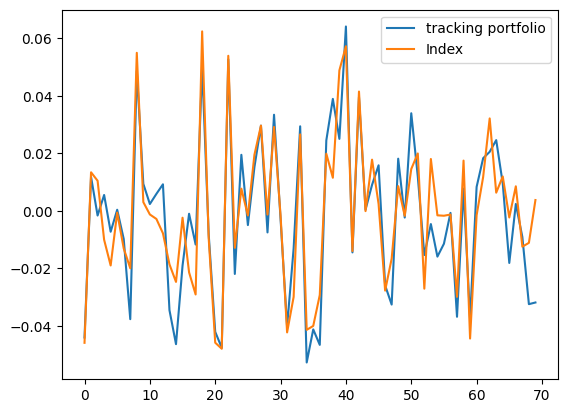

In [268]:
#plotting model.x portfolio from t=1,...,T

r_tracking = [((sum(model.q[j,t]*model.X1[j].value for j in model.j))/(sum(model.q[j,t-1]*model.X1[j].value for j in model.j)))-1  for t in range(1,T) ]
Index = [(model.I[t]/model.I[t-1])-1 for t in range(1,T)]
plt.plot(r_tracking,label = 'tracking portfolio')
plt.plot(Index , label = 'Index')
plt.legend()
plt.show()


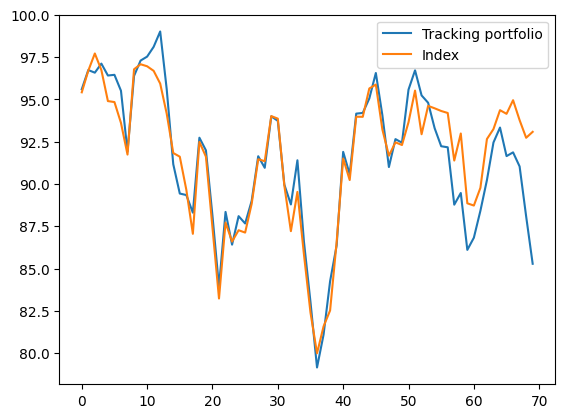

In [269]:
#in-sample
tracking = []
index = []
tracking.append( 100*(1+r_tracking[0]))
index.append(100*(1+Index[0]))
for i in range(1,len(Index)):
    tracking.append(tracking[i-1]*(1+r_tracking[i]))
    index.append(index[i-1]*(1+Index[i]))
plt.plot(tracking,label = 'Tracking portfolio')
plt.plot(index,label = 'Index')
plt.legend()
plt.show()

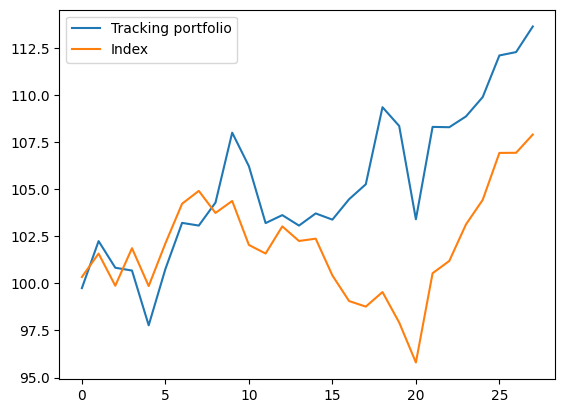

In [270]:
#out-of-sample performance
V_out =  np.array(out_prices.drop([index_ticket] ,axis = 1)).T
R_out = np.array([np.log(np.array(out_prices[index_ticket][t])/np.array(out_prices[index_ticket][t-1])) 
if t!=0 else np.log(np.array(out_prices[index_ticket][1])/np.array(out_prices[index_ticket][0]))  for t in range(V_out.shape[1]) ]) #return of index in period t
r_tracking = [(sum(V_out[j,t]*model.X1[j].value for j in model.j))/(sum(V_out[j,t-1]*model.X1[j].value for j in model.j))-1  for t in range(1,V_out.shape[1]) ]
Index = [R_out[t] for t in range(1,V_out.shape[1])]
tracking = []
index = []
tracking.append( 100*(1+r_tracking[0]))
index.append(100*(1+Index[0]))
for i in range(1,len(Index)):
    tracking.append(tracking[i-1]*(1+r_tracking[i]))
    index.append(index[i-1]*(1+Index[i]))
plt.plot(tracking,label = 'Tracking portfolio')
plt.plot(index,label = 'Index')
plt.legend()
plt.show()
